In [882]:
import numpy as np
import autograd.numpy as anp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction
from src.plotting_utils import *
from tqdm import tqdm

### Plotting Specifications

In [883]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [884]:
plt.rcParams['figure.figsize']

[5.5, 3.399186938124422]

In [885]:
from tueplots import figsizes
figsize_config = figsizes.neurips2021(nrows=1, ncols=1)
##figsize_config['figure.figsize'][1] = 0.5
plt.rcParams.update(figsize_config)

In [886]:
plt.rcParams['figure.figsize']

[5.5, 3.399186938124422]

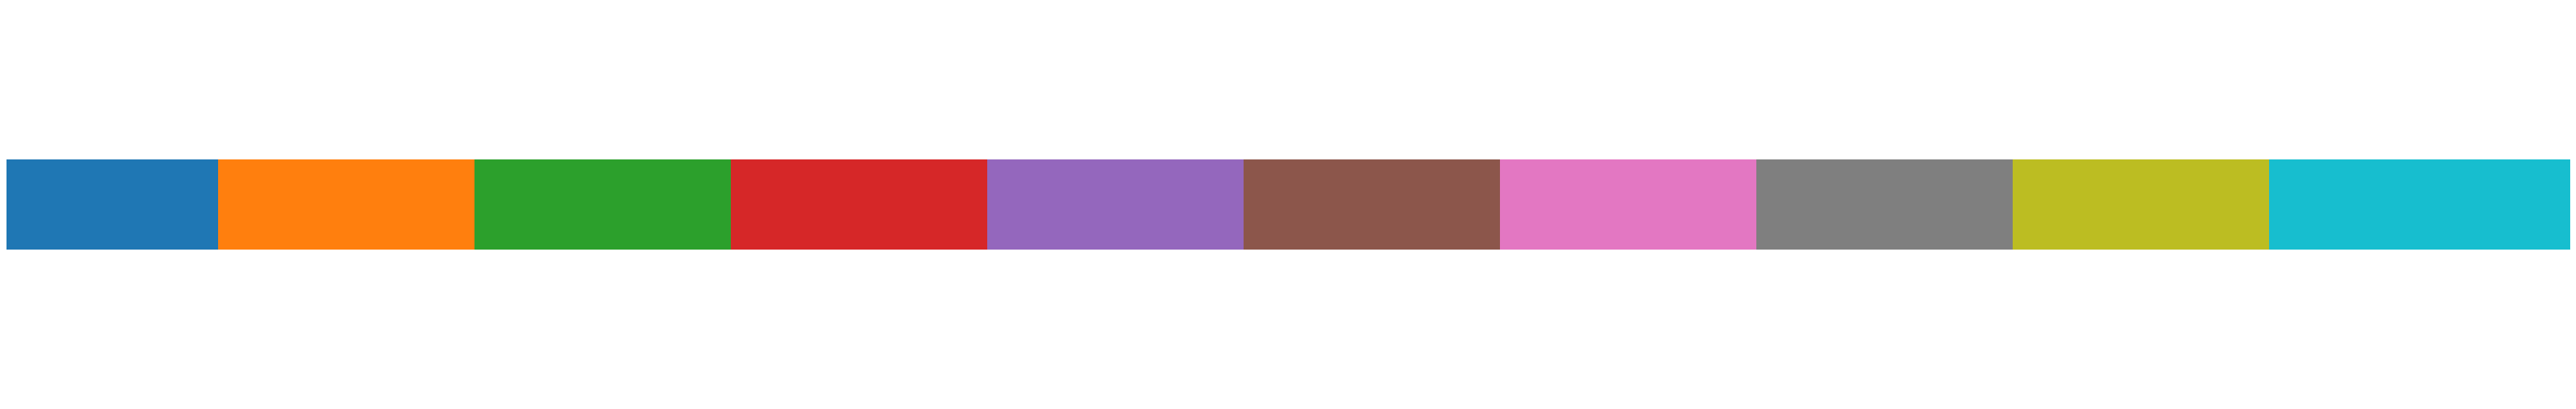

In [887]:
from cycler import cycler

# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### ODE Problem Setup

In [888]:
#define the ODE x_dot = f(x)
P=1.
beta=0.5/P
gamma=0.1

def vf(x):
    return anp.array([
        -1 * beta*x[0]*x[1],
        beta*x[0]*x[1] - gamma*x[1],
        gamma*x[1]
    ])

#define the initial value
y0 = anp.array([0.99, 0.01, 0.])

#set dimenisons
d, q = 3, 2

#Prior model for q=2 TODO: generalize this for variable q
A = lambda h: anp.array([[1.0, h, h**2/2.0], [0.0, 1.0, h], [0.0, 0.0, 1.0]])
sigma = 1.0 * 0.5
Q = lambda h: sigma**2 * anp.array([[h**5/20.0, h**4/8.0, h**3/6.0],
                                    [h**4/8.0, h**3/3.0, h**2/2.0],
                                    [h**3/6.0, h**2/2.0, h]])

# Taylor-mode init via autograd for q=2
Jvf = jacobian(vf)
x1 = vf(y0)
x2 = anp.dot(Jvf(y0), x1)  # second derivative
#print(x2,Jvf(y0)@x1)
mu_0 = anp.concatenate([y0, x1, x2])  # shape (d*(q+1),)
#mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = anp.eye(d*(q+1)) * 0.0


# Discretization
t0, t1 = 0.0, 100.0
N = 100
ts = anp.linspace(t0, t1, num=N+1, endpoint=True)
h = (t1 - t0) / N

# Constant step consequences
A_h =  anp.kron(A(h), anp.eye(d))
Q_h = anp.kron(Q(h), anp.eye(d))
b_h = anp.zeros((q+1)*d)
R_h = anp.eye(d)

#valid projections for q=2, TODO: generalize for variable q
E0 = anp.array([1.0, 0.0, 0.0])
E1 = anp.array([0.0, 1.0, 0.0])
E0 = anp.kron(E0, anp.eye(d))
E1 = anp.kron(E1, anp.eye(d))

# Measurement operator: x_dot - f(x) = 0
def g(X):
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    return x_dot - vf(x)


jacobian_g = jacobian(g)

# Data
z_sequence = anp.zeros((N, d))

In [889]:
A_h

array([[1. , 0. , 0. , 1. , 0. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 1. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [890]:
jacobian_g(mu_0)

array([[ 0.005,  0.495,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ],
       [-0.005, -0.395,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,
         0.   ]])

In [219]:
# Measurement operator: x_dot - f(x) = 0
def g_conserved(X):
    #normnal measurement 
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    z_ode = x_dot - vf(x)
    #conservation
    z_conserved = anp.array([P-anp.sum(x)])
    return anp.concatenate([z_ode, z_conserved])

jacobian_g_conserved = jacobian(g_conserved)
z_sequence_conserved = anp.zeros((N, d+1))
R_h_conserved = anp.eye(d+1)
jacobian_g_conserved(mu_0).shape  # expected shape (d+1, 3*d)

(4, 9)

### Compute and Plot filtering results

In [891]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [221]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h_conserved, g_conserved, jacobian_g_conserved, z_sequence_conserved, N)

In [892]:
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

In [893]:
zs = []
zf_var = []
for k in range(m_sequence.shape[0]):
    zs.append(g(m_sequence[k,:]))
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)

zs = np.asarray(zs, dtype=float)
zf_var = np.asarray(zf_var, dtype=float)

### Iterative Forward plotting

In [894]:
m_sequence.shape

(101, 9)

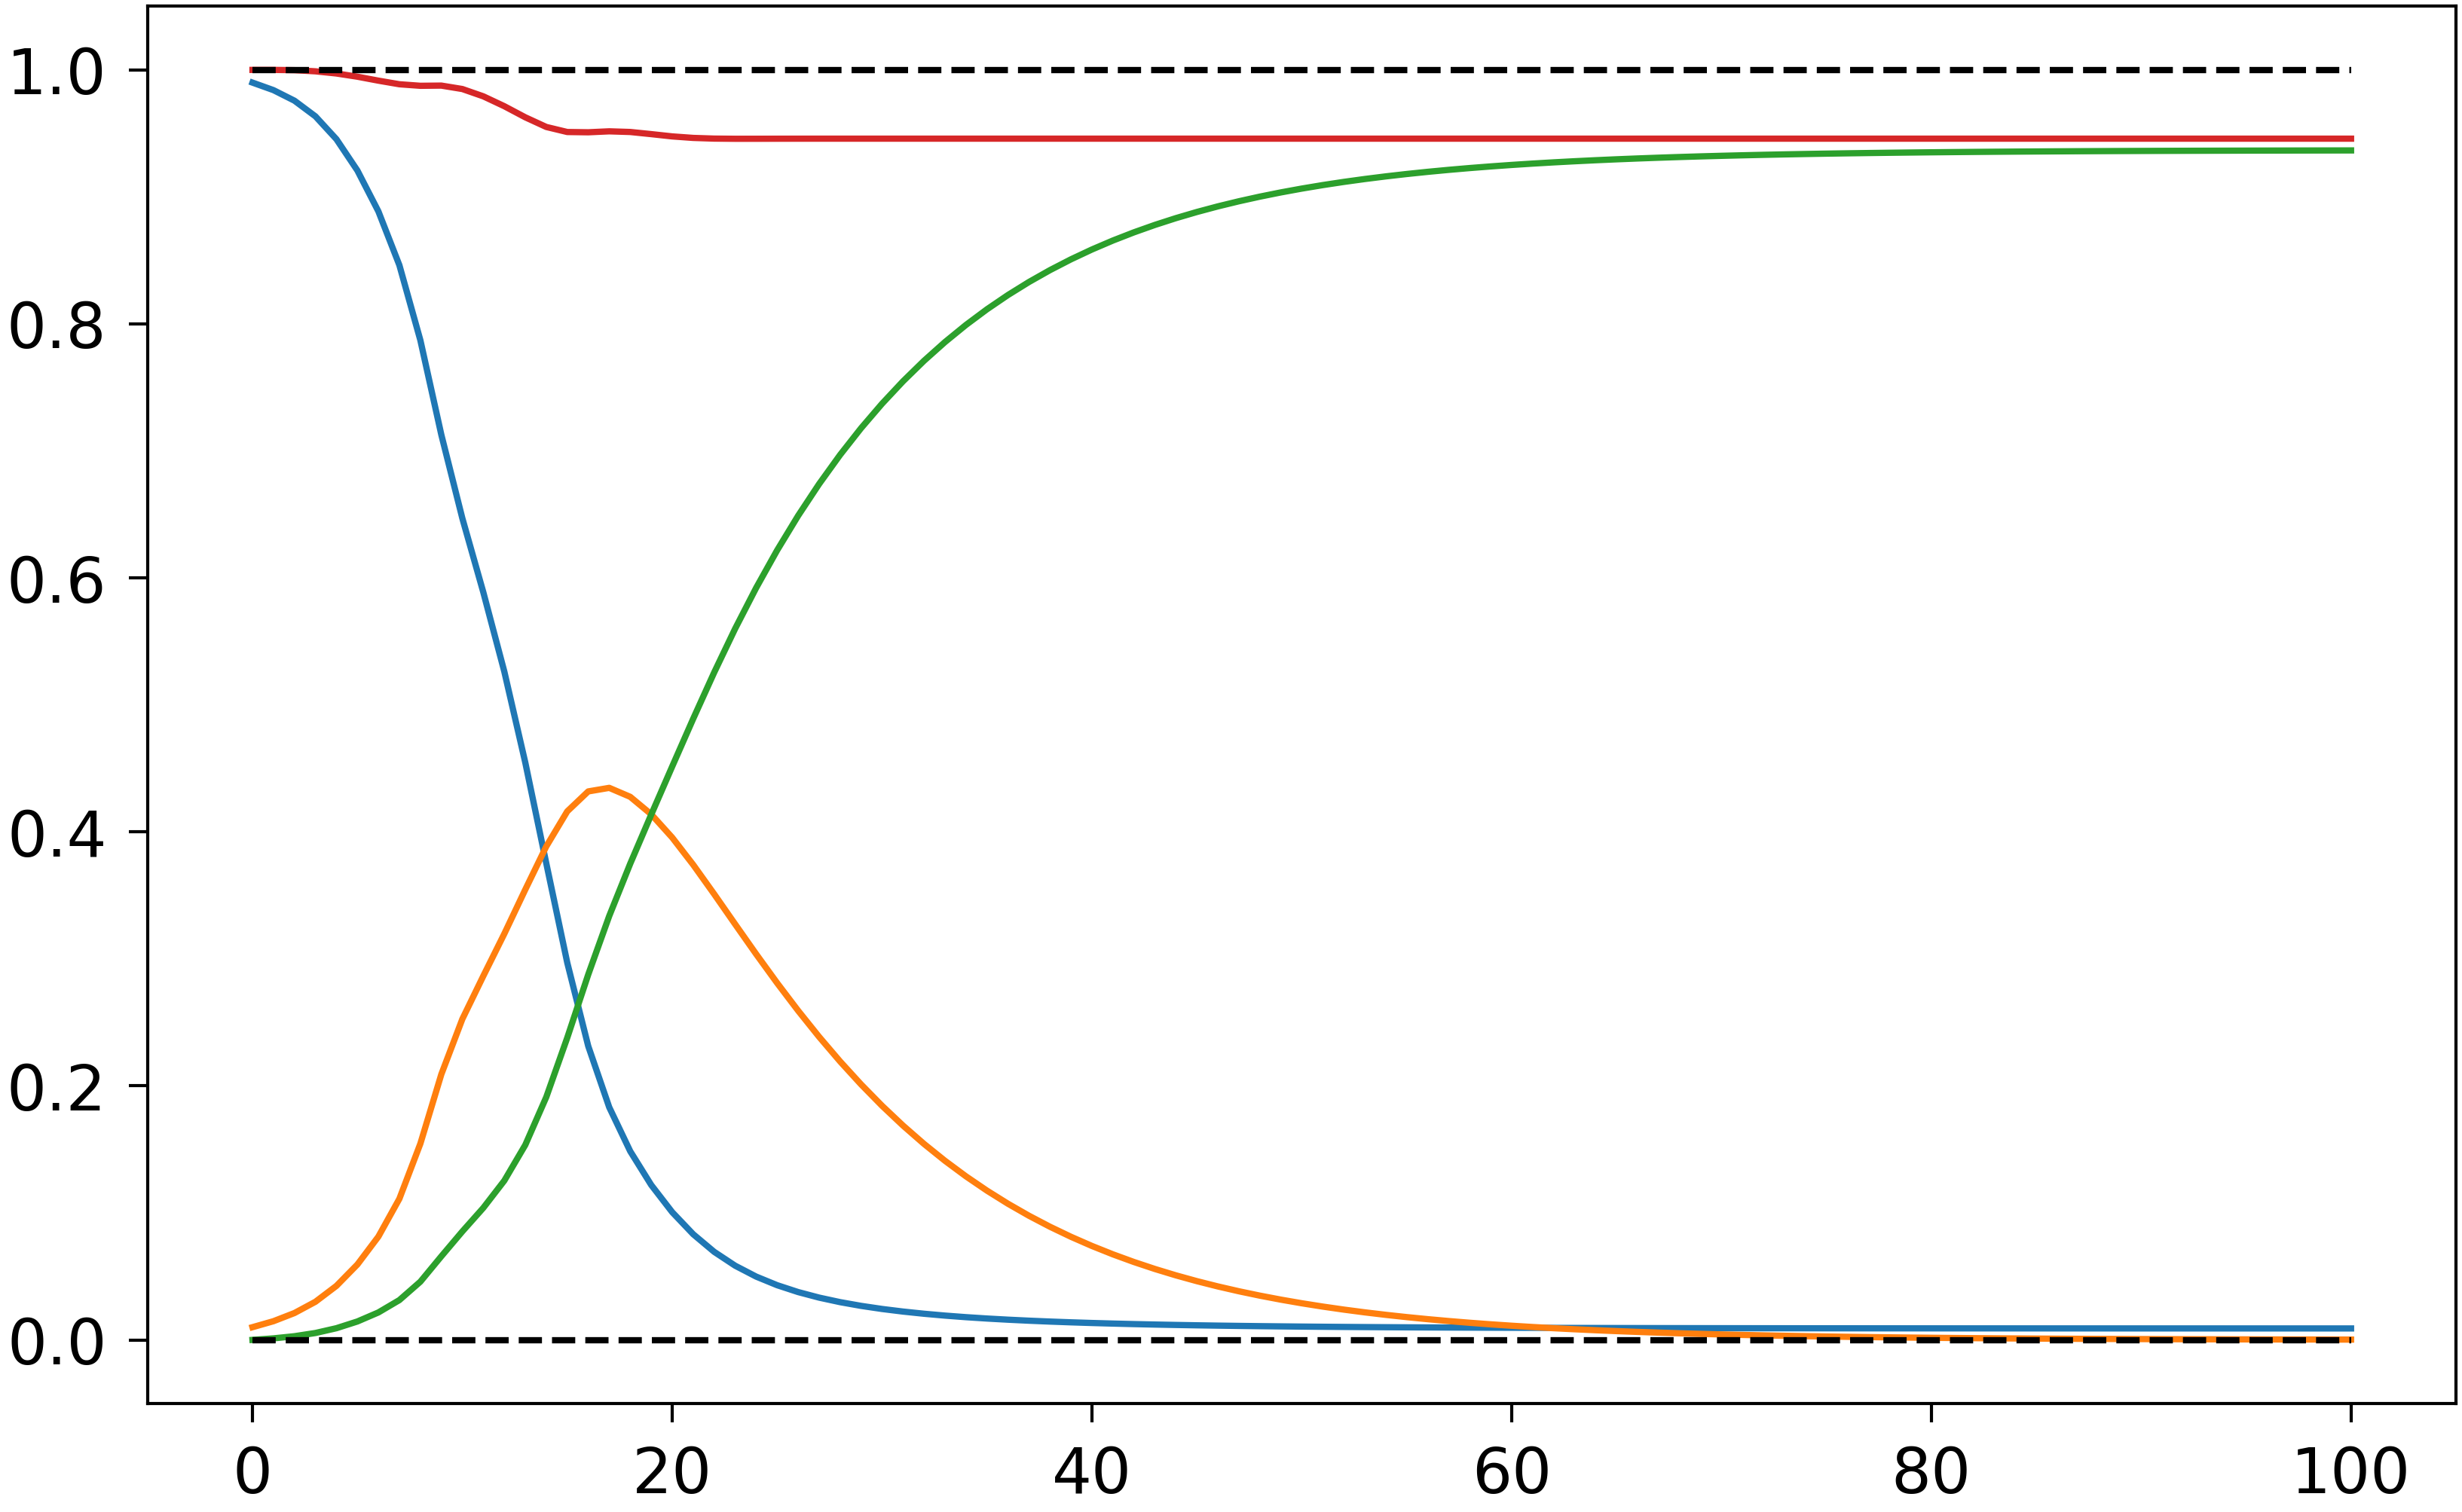

In [895]:
plt.figure()
plt.plot(ts, m_sequence[:,:3])
plt.plot(ts, m_sequence[:,0]+m_sequence[:,1]+m_sequence[:,2])
plt.plot(ts, np.zeros_like(ts), linestyle='--', color='black')
plt.plot(ts, 1*np.ones_like(ts), linestyle='--', color='black')
plt.show()

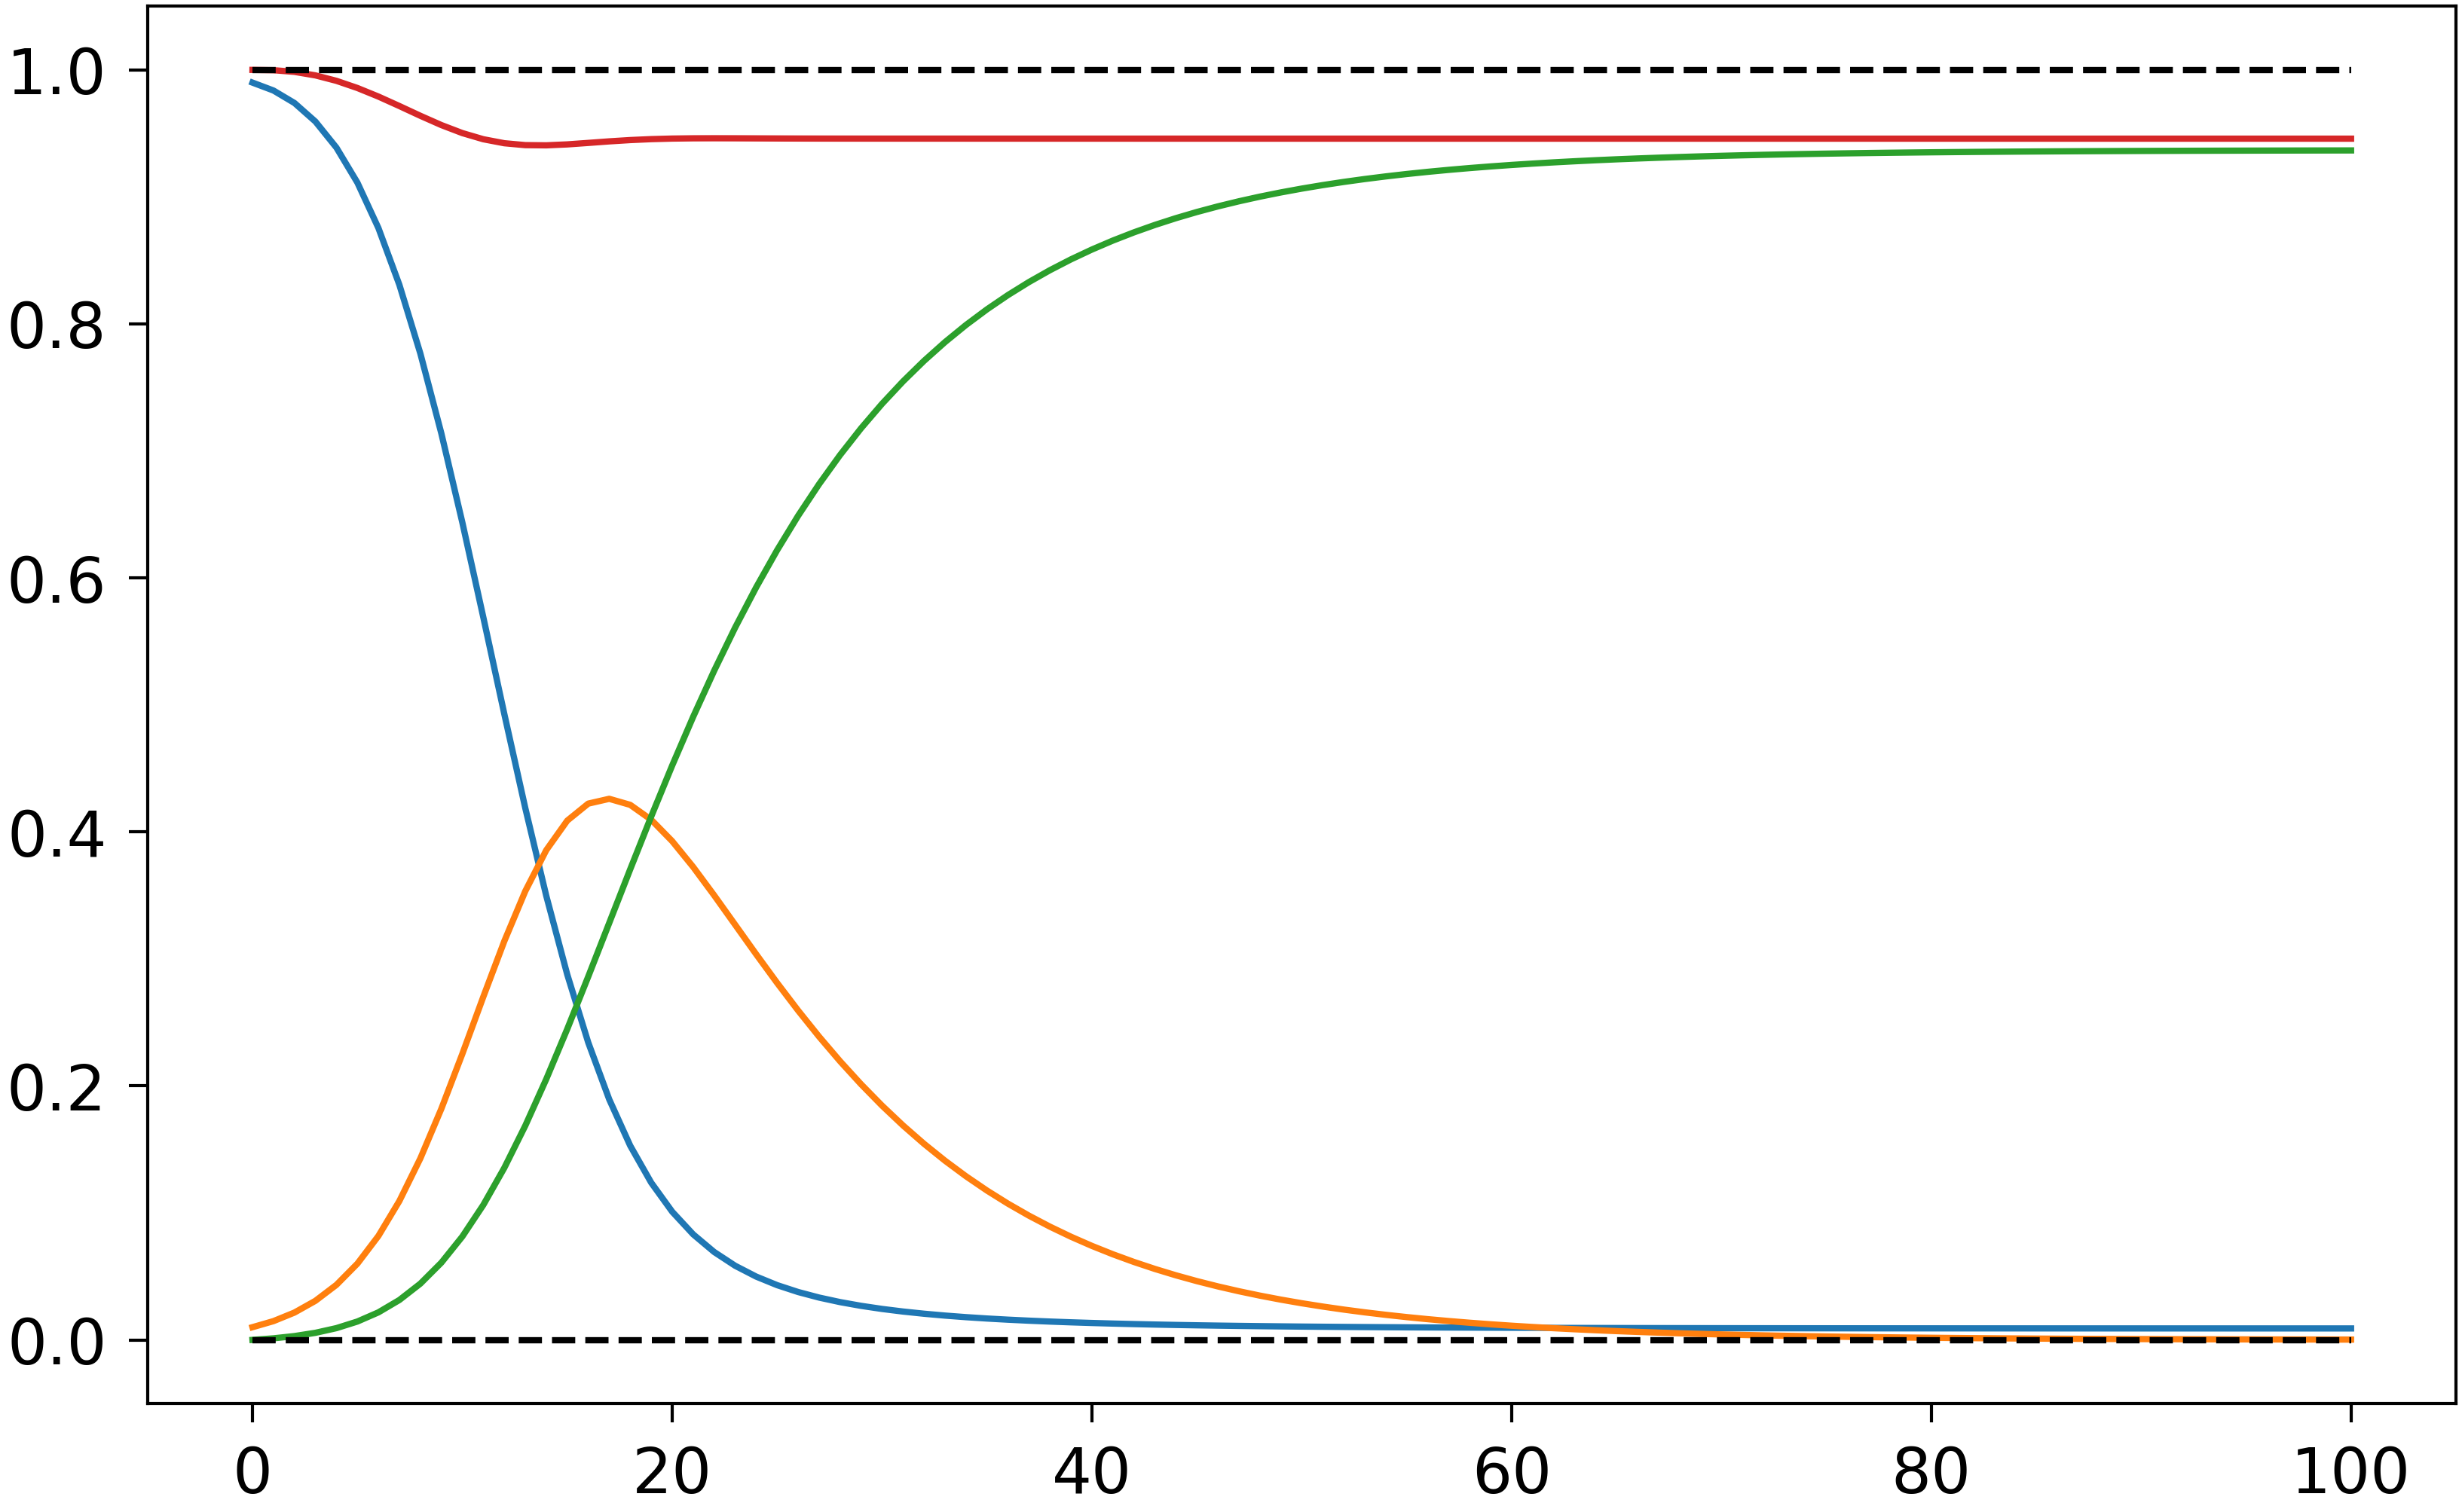

In [896]:
plt.figure()
plt.plot(ts, m_smoothed[:,:3])
plt.plot(ts, m_smoothed[:,0]+m_smoothed[:,1]+m_smoothed[:,2])
plt.plot(ts, np.zeros_like(ts), linestyle='--', color='black')
plt.plot(ts, 1*np.ones_like(ts), linestyle='--', color='black')
plt.show()

### Add latent variable

In [ ]:
# Data loading 
data = np.load("data_info.npz")
S = data["sird_data"][:, 0] / 1000
I = data["sird_data"][:, 1] / 1000
R = (data["sird_data"][:, 2] + data["sird_data"][:, 3]) / 1000

data_grid = np.array(data["data_grid"], dtype=int)
# print(data["date_range_x"].shape)
data_dates = data["date_range_x"][data_grid]

In [318]:
S[0]+I[0]+R[0]

np.float64(1.0000000399999998)

In [865]:
#define the ODE x_dot = f(x)
P=1.
gamma=0.06

def vf(x):
    return anp.array([
        -1 * x[3]*x[0]*x[1],
        x[3]*x[0]*x[1] - gamma*x[1],
        gamma*x[1],
        0
    ])

#define the initial value
y0 = anp.array([S[0], I[0], R[0], 0.5])

#set dimenisons
d, q = 4, 2

#Prior model for q=2 TODO: generalize this for variable q
A = lambda h: anp.array([[1.0, h, h**2/2.0], [0.0, 1.0, h], [0.0, 0.0, 1.0]])
Q = lambda h: anp.array([[h**5/20.0, h**4/8.0, h**3/6.0],
                                    [h**4/8.0, h**3/3.0, h**2/2.0],
                                    [h**3/6.0, h**2/2.0, h]])

# Taylor-mode init via autograd for q=2
Jvf = jacobian(vf)
x1 = vf(y0)
x2 = anp.dot(Jvf(y0), x1)  # second derivative
#print(x2,Jvf(y0)@x1)
mu_0 = anp.concatenate([y0, x1, x2])  # shape (d*(q+1),)
#mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = anp.eye(d*(q+1)) * 0.0
Sigma_0[3,3]=1.
Sigma_0[7,7]=1.
Sigma_0[11,11]=1.

# Discretization
t0, t1 = 0.0, 555.0
N = 555
ts = anp.linspace(t0, t1, num=N+1, endpoint=True)
h = (t1 - t0) / N

#hyperparameters for multiple varialbes
sigma_x = 0.00001
sigma_beta = 0.0003

# Constant step consequences
A_h =  anp.kron(A(h), anp.eye(d))
Q_h = anp.kron(Q(h), anp.diag([sigma_x, sigma_x, sigma_x, sigma_beta])**2)
b_h = anp.zeros((q+1)*d)
R_h = anp.eye(d)

#valid projections for q=2, TODO: generalize for variable q
E0 = anp.array([1., 0., 0.])
E1 = anp.array([0., 1., 0.])
E0 = anp.kron(E0, anp.eye(d))
E1 = anp.kron(E1, anp.eye(d))

# Measurement operator: x_dot - f(x) = 0
def g_conserved(X):
    #normnal measurement 
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    z_ode = x_dot - vf(x)
    #conservation
    z_conserved = anp.array([P-anp.sum(x[:3])])
    #Actual observation of Infected persons
    z_observation = anp.array([x[1]])

    return anp.concatenate([z_ode[:3], z_conserved, z_observation])

jacobian_g_conserved = jacobian(g_conserved)
z_sequence_conserved = anp.zeros((N, d+1))
z_sequence_conserved[:,-1] = I[1:]
R_h_conserved = anp.eye(d+1)*0.0005
R_h_conserved[:4, :4] *= 0.01
jacobian_g_conserved(mu_0).shape  # expected shape (d+1, 3*d)

(5, 12)

In [866]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h_conserved, g_conserved, jacobian_g_conserved, z_sequence_conserved, N)

In [867]:
m_sequence, P_sequence = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

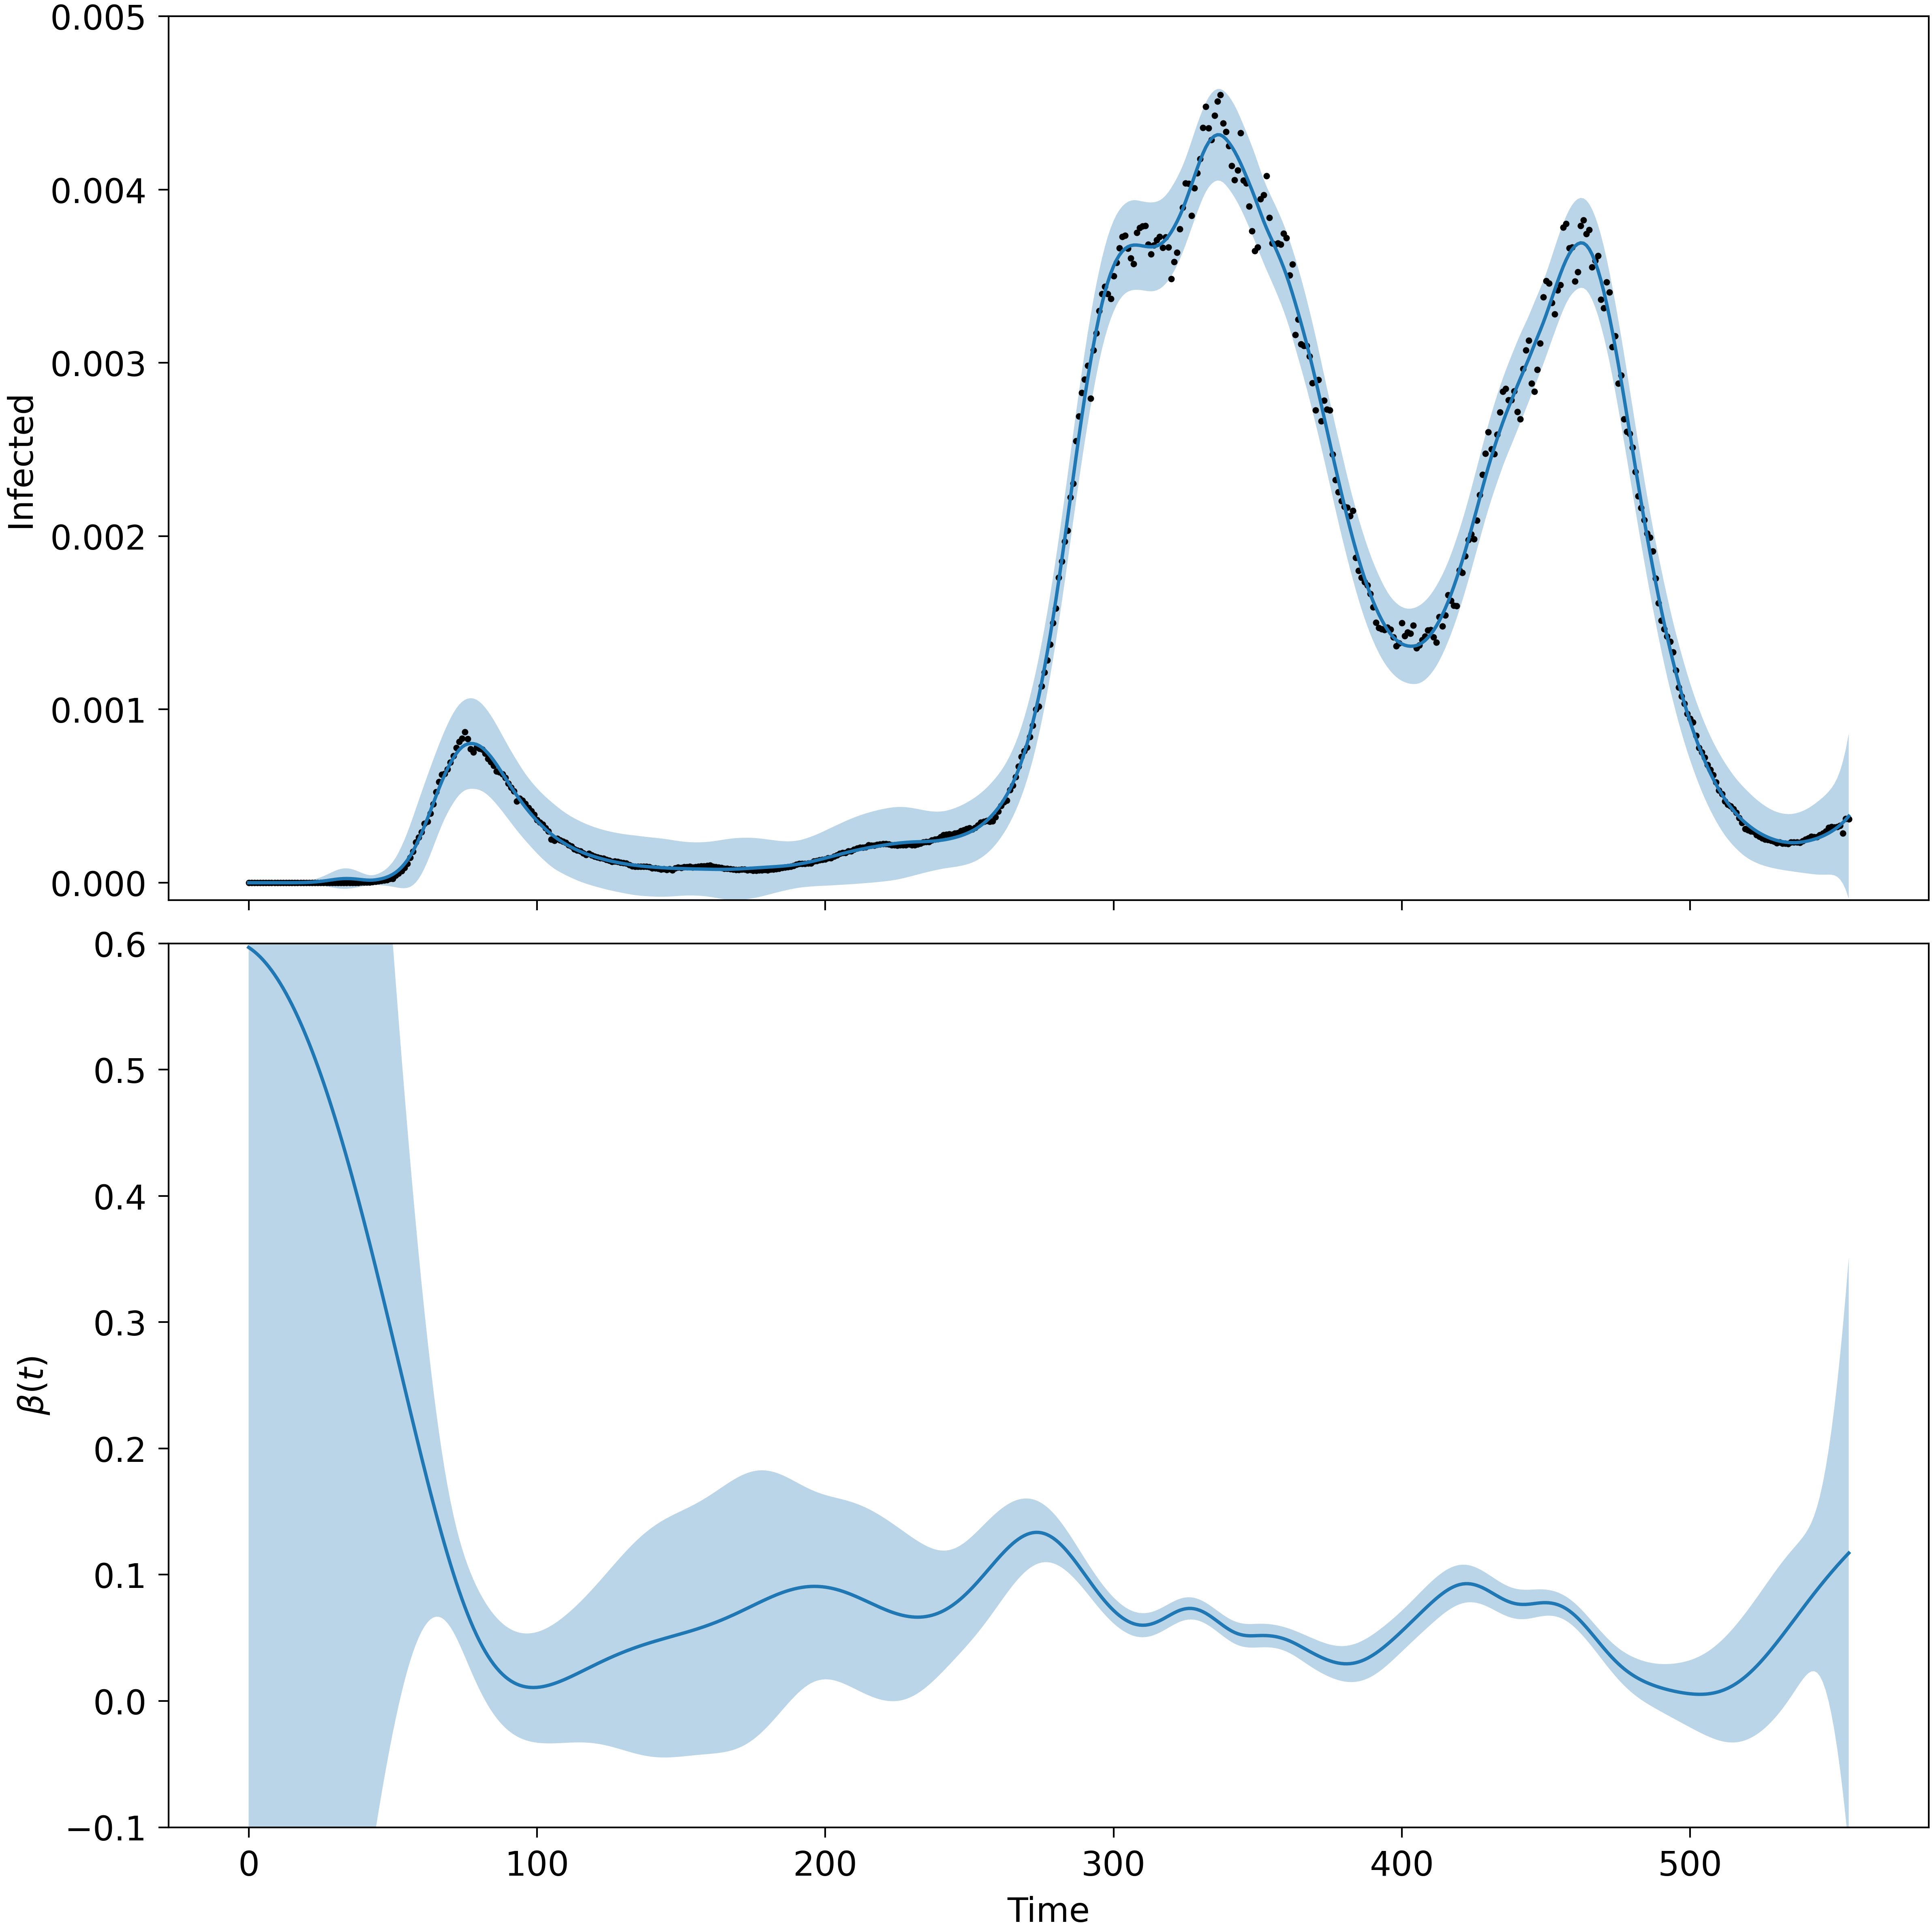

In [881]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# First subplot: Infected
axs[0].plot(ts[:], m_sequence[:,1])
P = P_sequence[:,1,1]
margin = 2 * np.sqrt(P)
axs[0].fill_between(ts, m_sequence[:,1]-margin, m_sequence[:,1]+margin, alpha=0.3)
axs[0].scatter(ts, I, color='black', s=2)
axs[0].set_ylabel("Infected")
axs[0].set_ylim([-0.0001,0.005])

# Second subplot: beta(t)
axs[1].plot(ts[:], m_sequence[:,3])
P = P_sequence[:,3,3]
margin = 2 * np.sqrt(P)
axs[1].fill_between(ts, m_sequence[:,3]-margin, m_sequence[:,3]+margin, alpha=0.3)
axs[1].set_ylim(-0.1, 0.6)
axs[1].set_ylabel(r'$\beta(t)$')

plt.xlabel("Time")
plt.show()

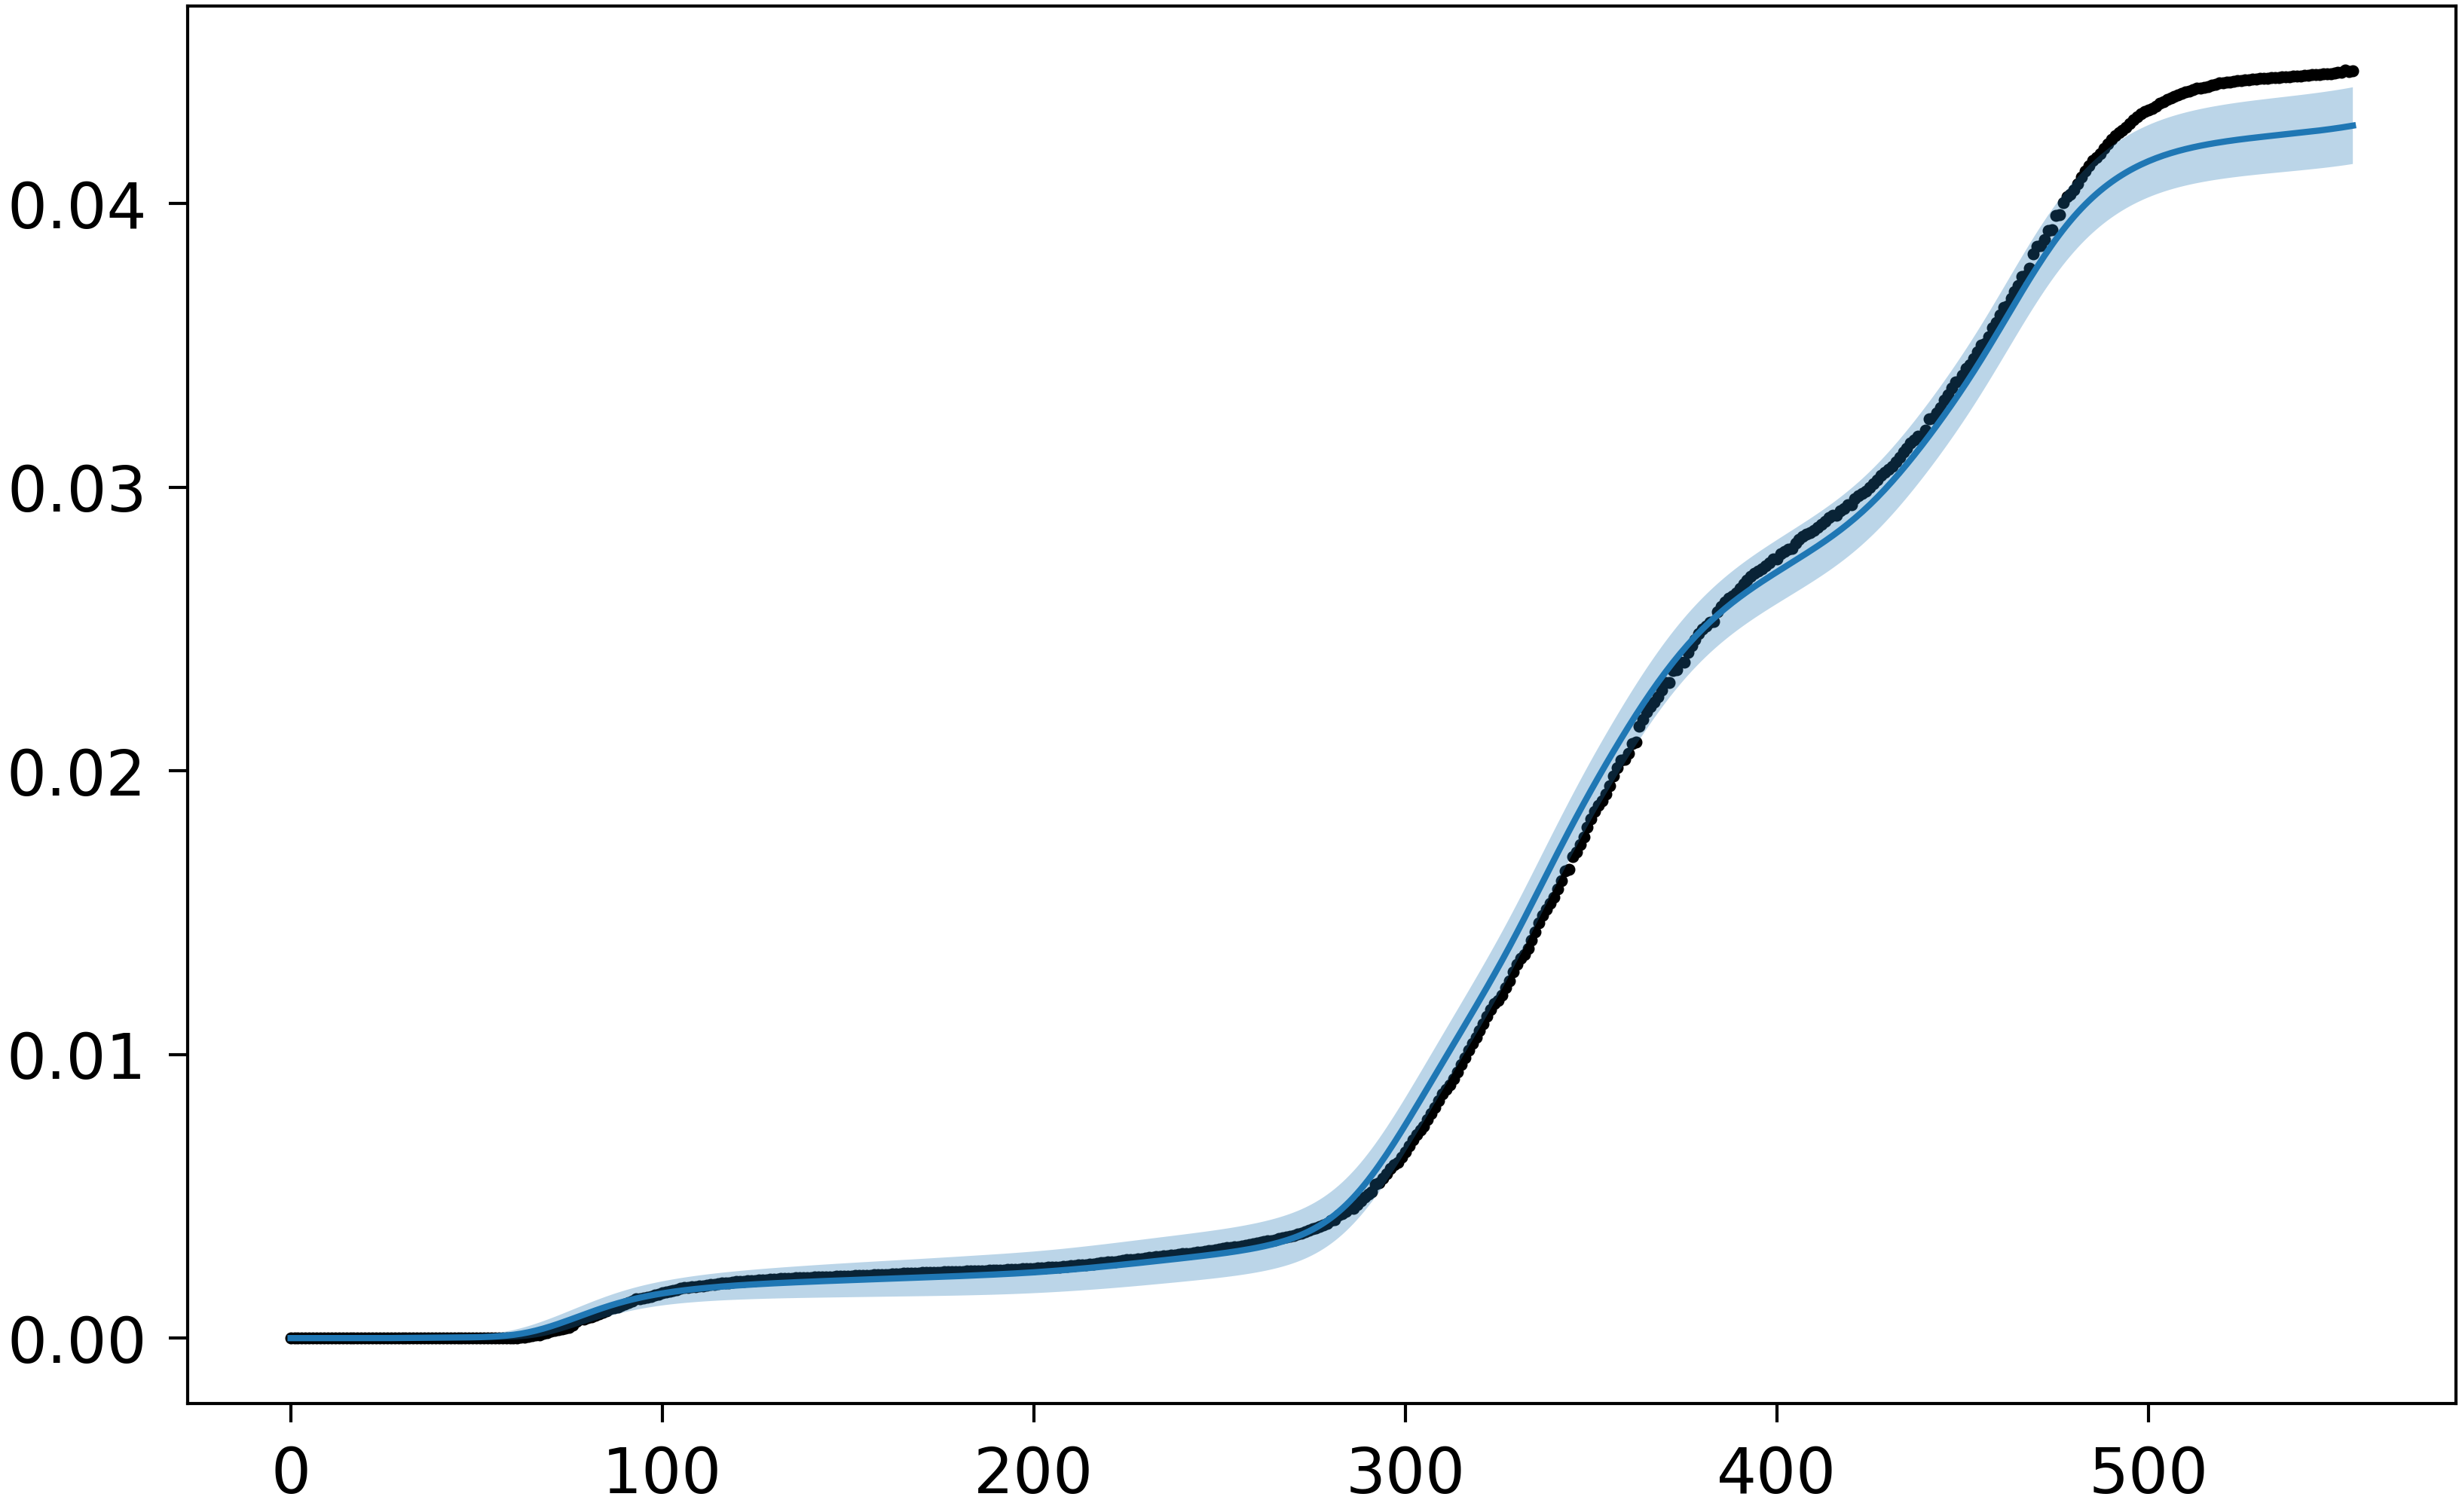

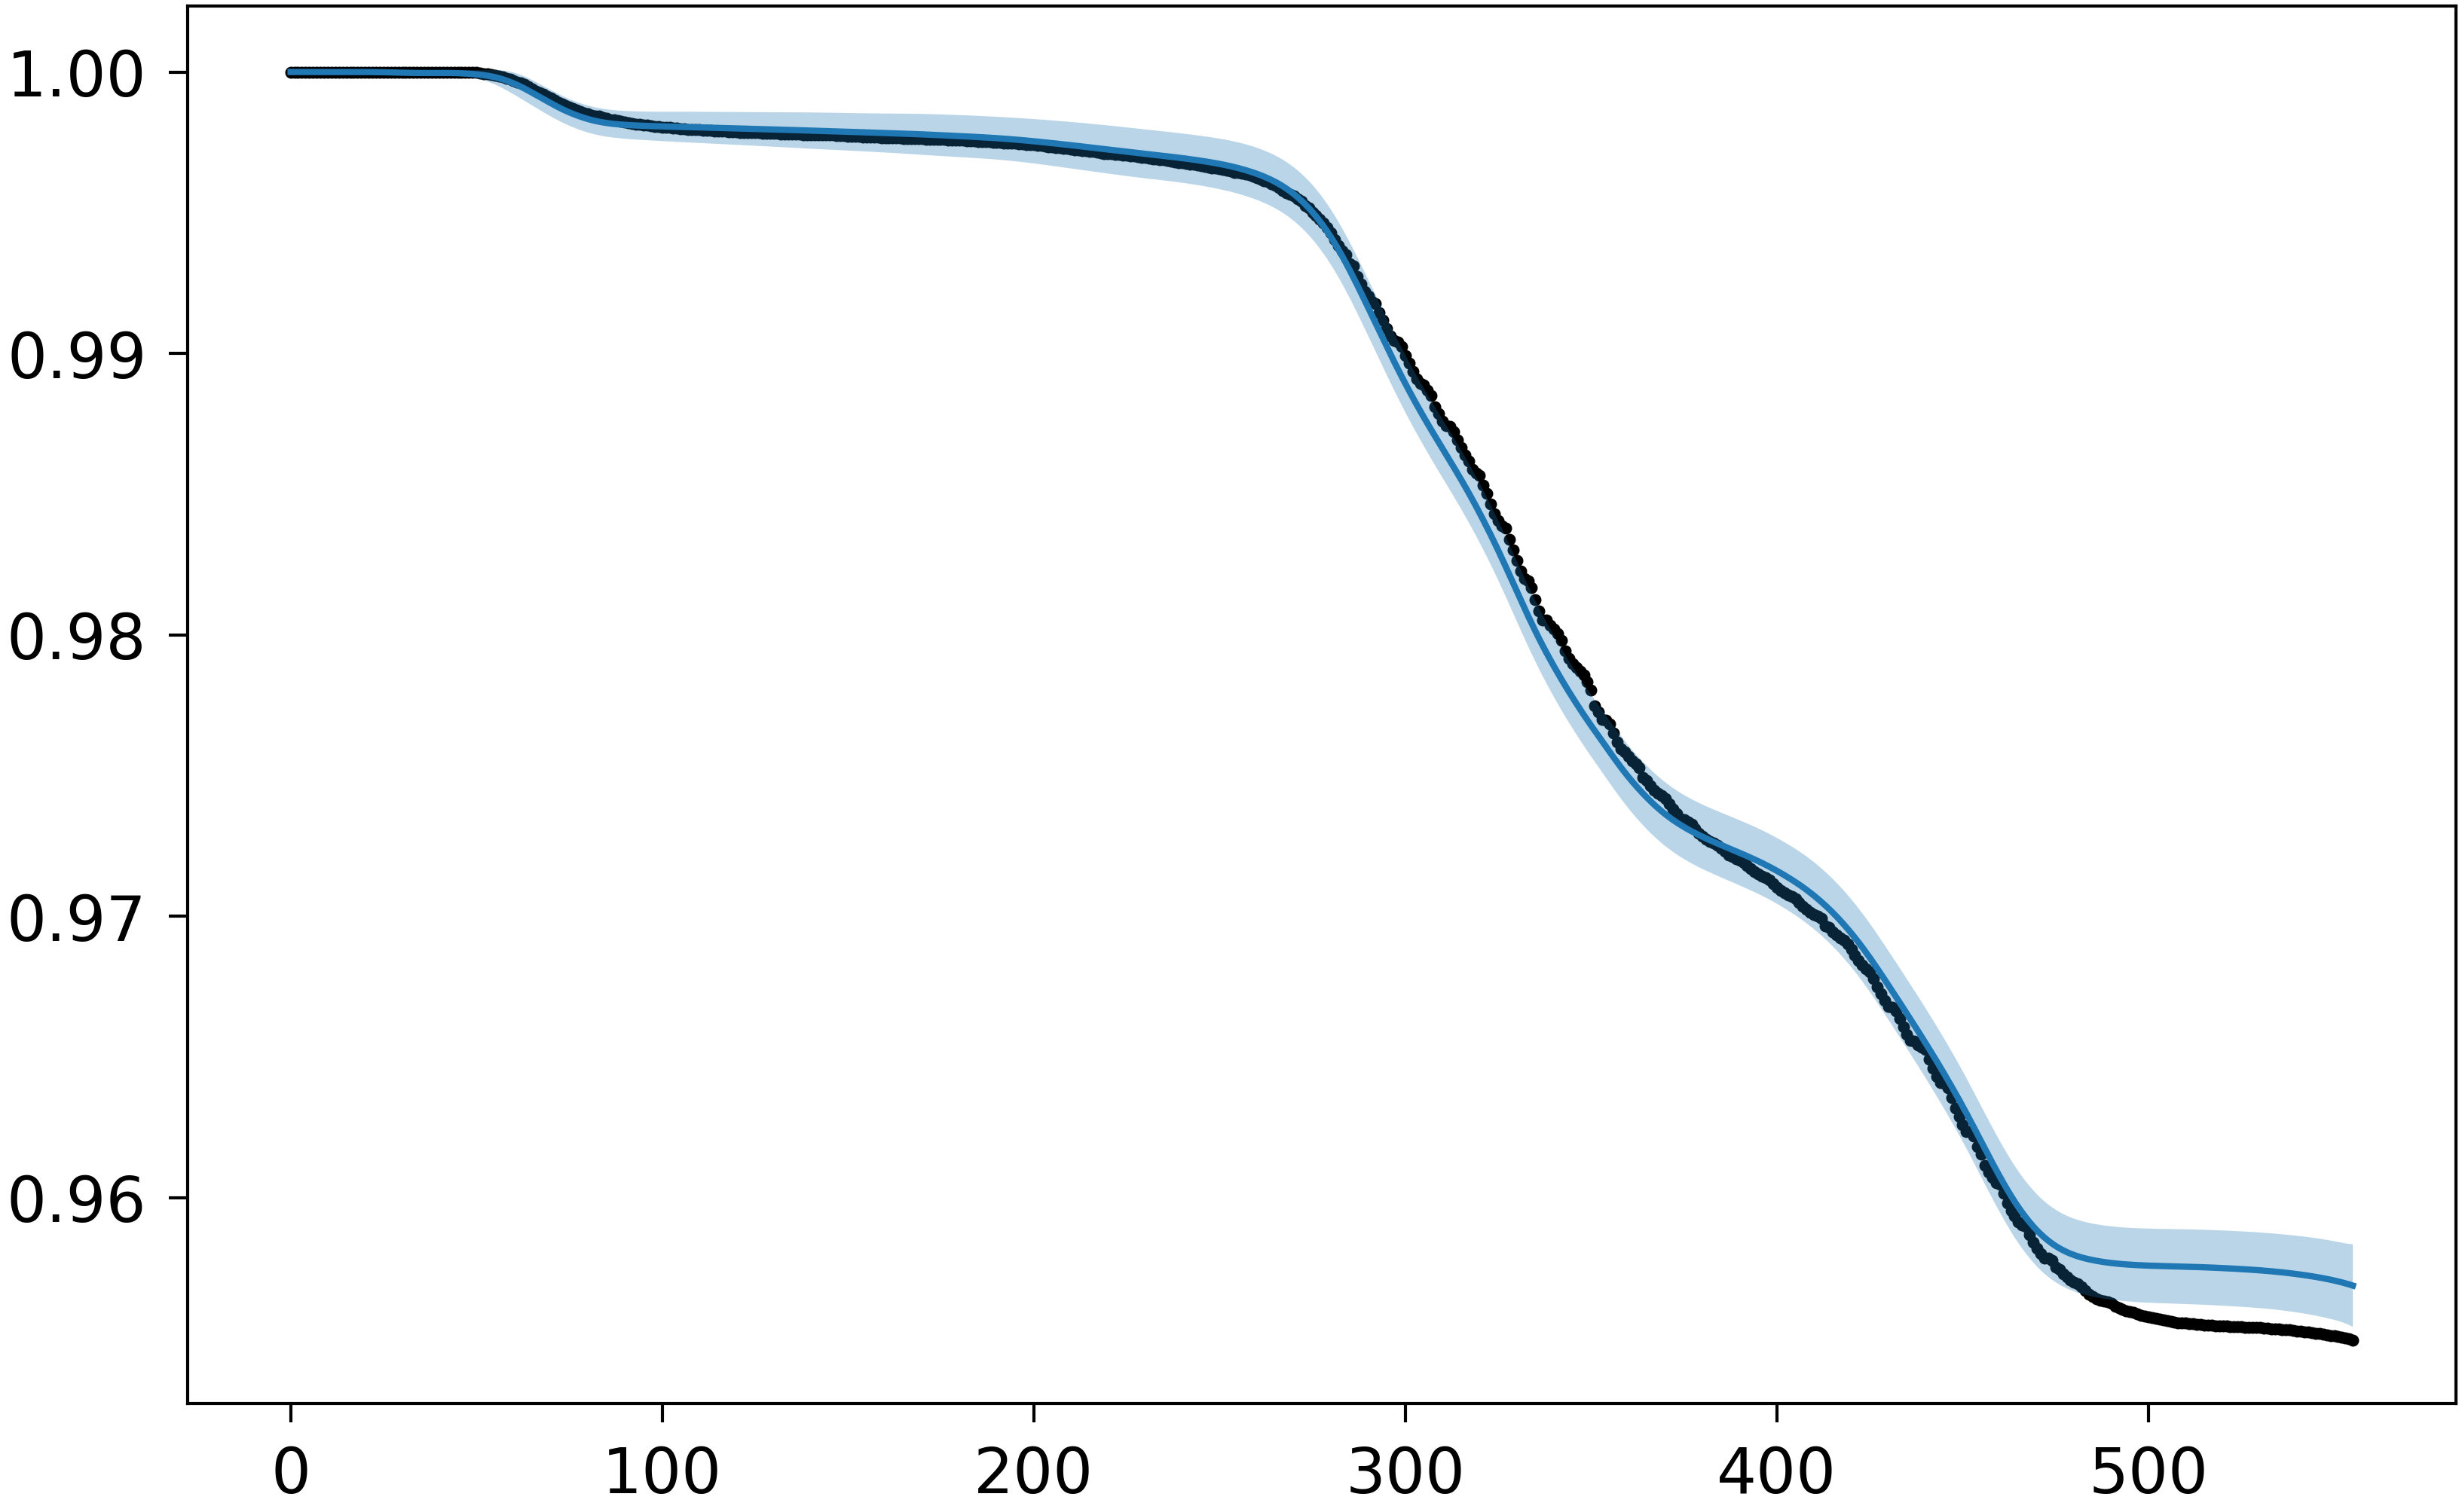

In [877]:
plt.figure()
plt.plot(ts[:], m_sequence[:,2])
plt.scatter(ts, R, color='black', s=2)
P = P_sequence[:,2,2]
margin = 2 * np.sqrt(P)
plt.fill_between(ts, m_sequence[:,2]-margin, m_sequence[:,2]+margin, alpha=0.3)
plt.show()

plt.figure()
plt.plot(ts[:], m_sequence[:,0])
plt.scatter(ts, S, color='black', s=2)
P = P_sequence[:,0,0]
margin = 2 * np.sqrt(P)
plt.fill_between(ts, m_sequence[:,0]-margin, m_sequence[:,0]+margin, alpha=0.3)
plt.show()

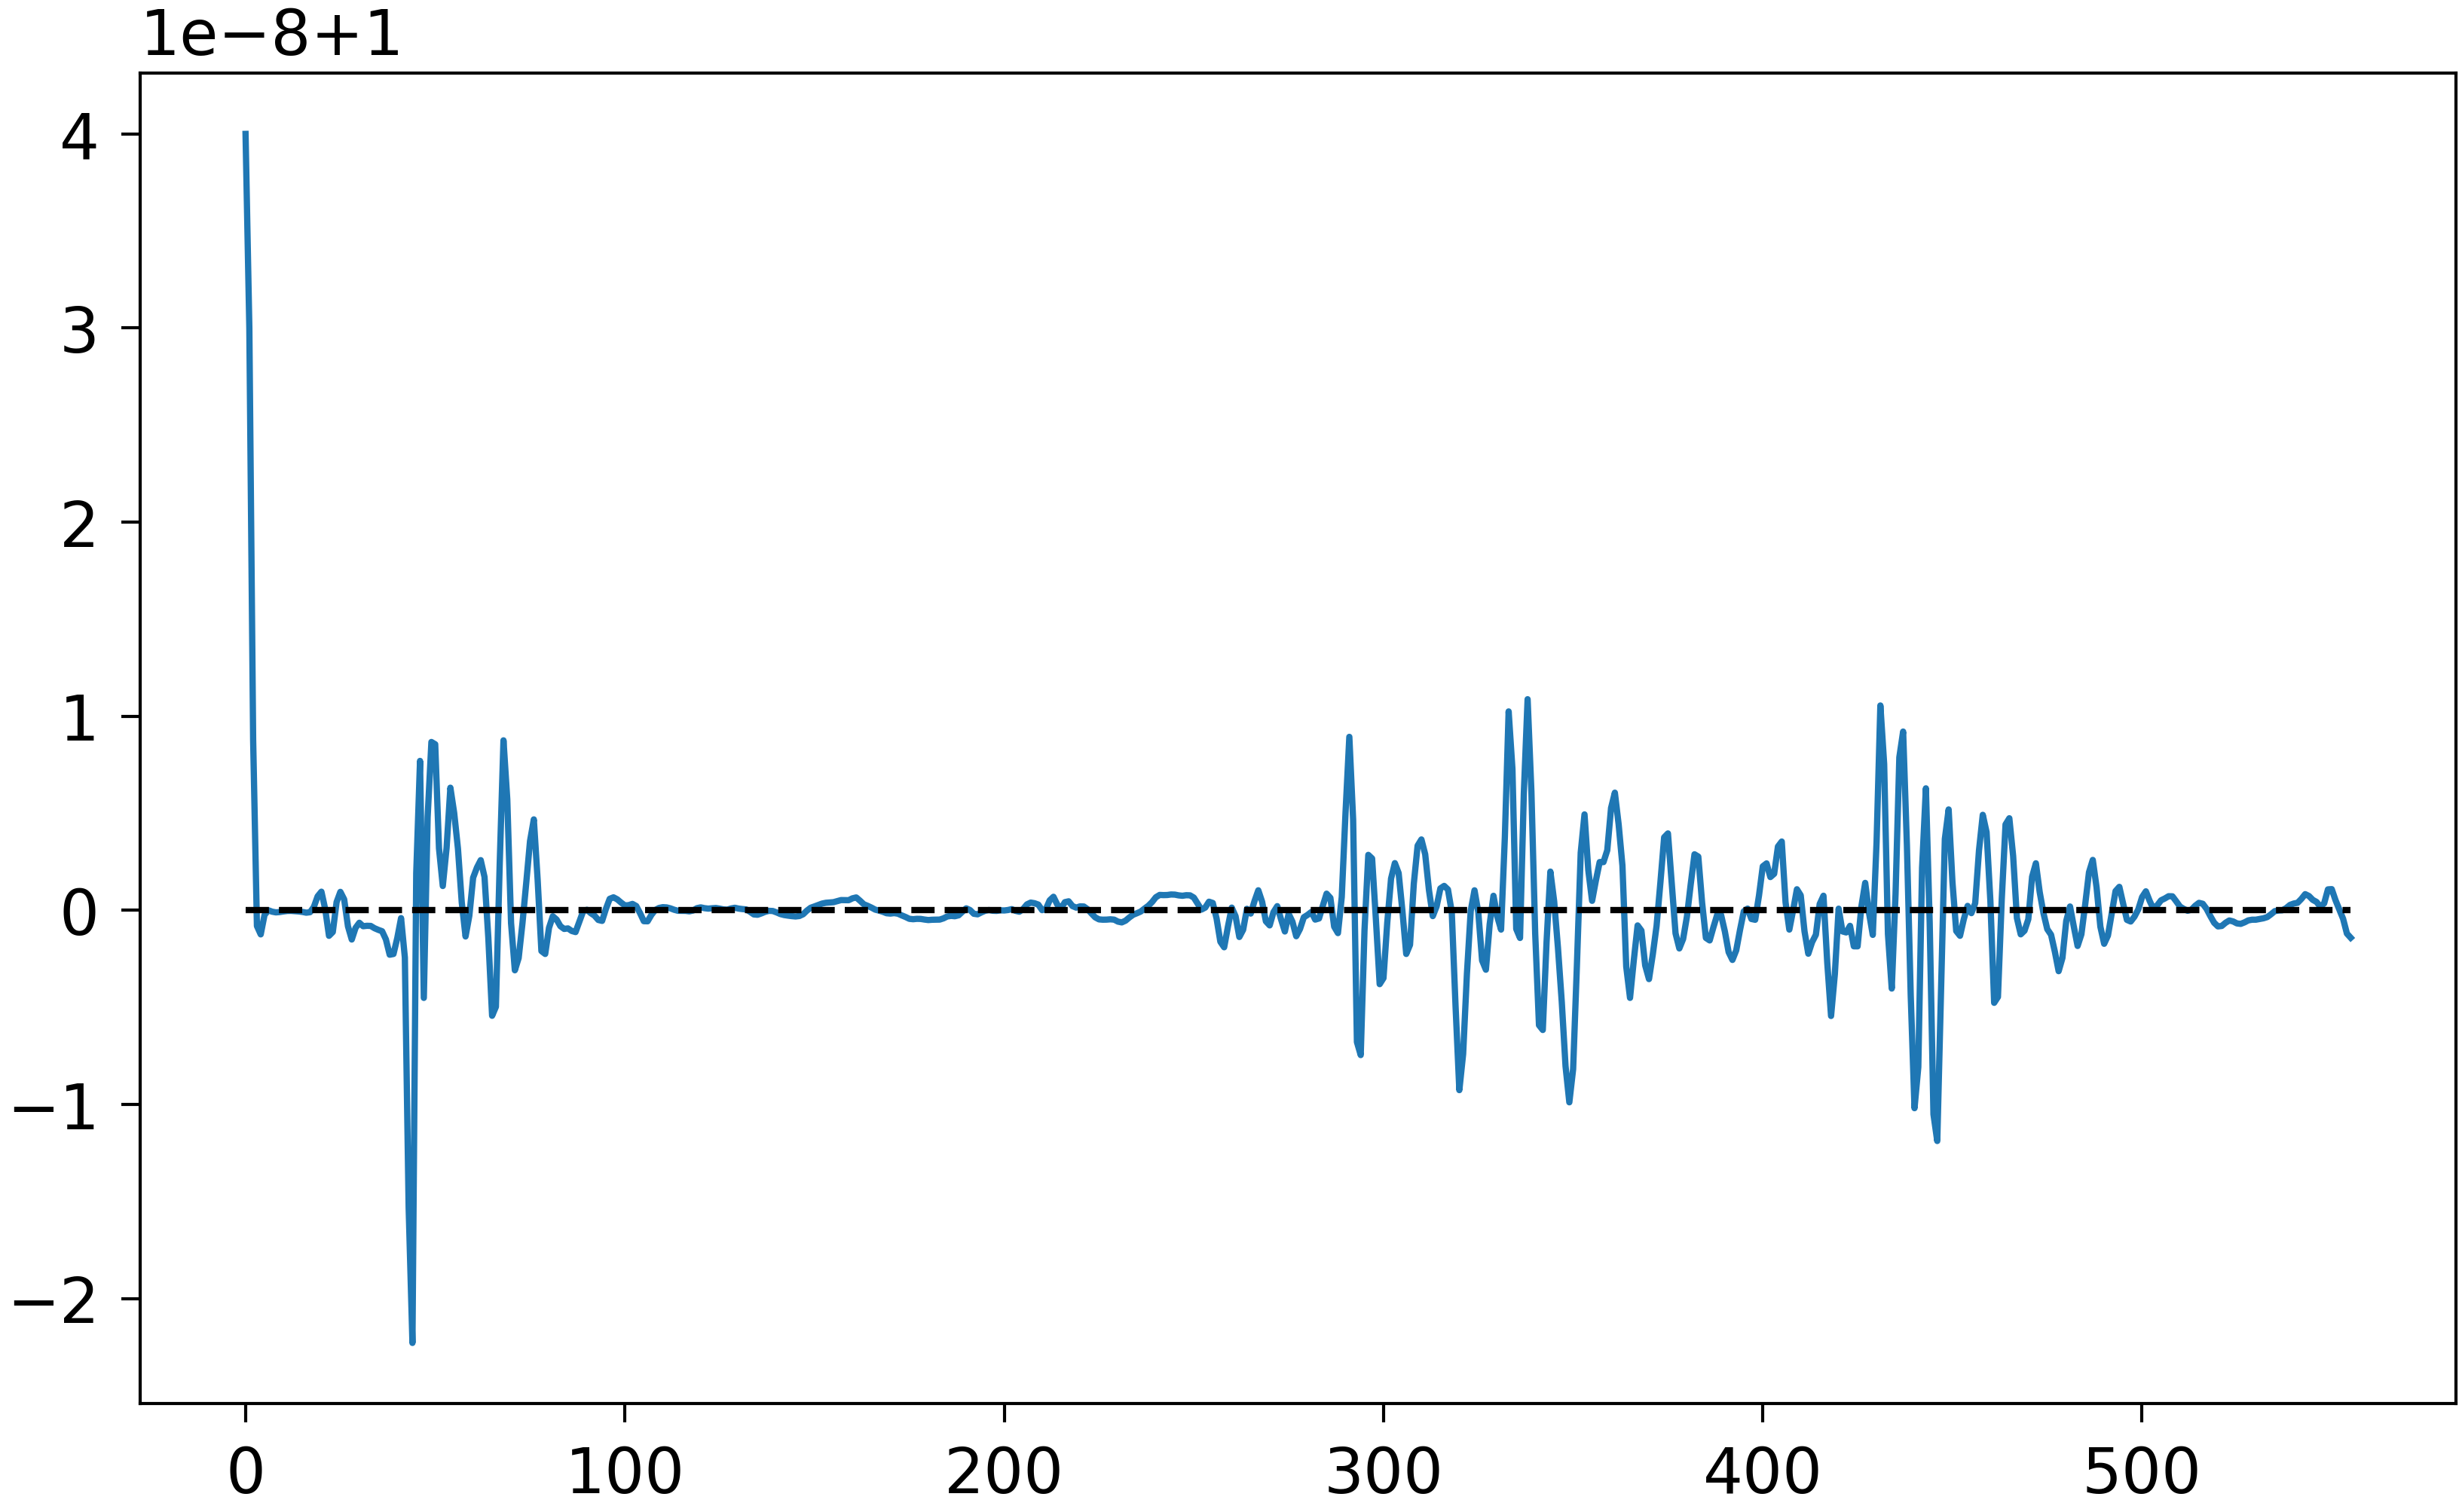

In [878]:
plt.figure()
plt.plot(ts, m_sequence[:,0]+m_sequence[:,1]+m_sequence[:,2])
#plt.ylim([0.99,1.01])
plt.plot(ts, np.ones_like(ts), linestyle='--', color='black')
plt.show()
